In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [3]:
from goexplore import *

In [4]:
with open('atari_games_104.txt') as f:
    env_ids = [a.strip() for a in f.readlines()]
with open('atari_games_57.txt') as f:
    env_ids_ignore = [a.strip() for a in f.readlines()]
[env_id for env_id in env_ids if env_id not in env_ids_ignore]

['Adventure',
 'AirRaid',
 'Atlantis2',
 'Backgammon',
 'BasicMath',
 'Blackjack',
 'Carnival',
 'Casino',
 'Crossbow',
 'Darkchambers',
 'DonkeyKong',
 'Earthworld',
 'ElevatorAction',
 'Entombed',
 'Et',
 'FlagCapture',
 'Frogger',
 'Galaxian',
 'Hangman',
 'HauntedHouse',
 'HumanCannonball',
 'JourneyEscape',
 'Kaboom',
 'KeystoneKapers',
 'KingKong',
 'Klax',
 'Koolaid',
 'LaserGates',
 'LostLuggage',
 'MarioBros',
 'MiniatureGolf',
 'MrDo',
 'Othello',
 'Pacman',
 'Pitfall2',
 'Pooyan',
 'SirLancelot',
 'SpaceWar',
 'Superman',
 'Tetris',
 'TicTacToe3d',
 'Trondead',
 'Turmoil',
 'VideoCheckers',
 'VideoChess',
 'VideoCube',
 'WordZapper']

In [308]:
archive = np.load('data/goexplore/goexplore_Pong_0.npy', allow_pickle=True).item()

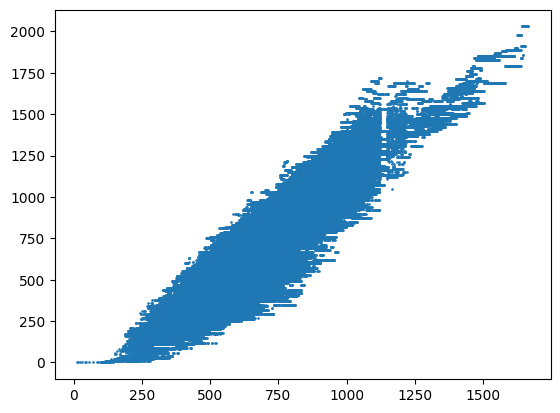

In [309]:
cells = list(archive.values())
rets = [cell.running_ret for cell in cells]
tlens = [len(cell.trajectory) for cell in cells]
plt.scatter(tlens, rets, s=10/np.log(len(rets)))

In [134]:
cells = list(archive.values())
rets = [cell.running_ret for cell in cells]
cells_best = [cell for cell in cells if cell.running_ret==np.max(rets)]
print(f'Max running return found: {np.max(rets)}')
print(f'Total cells: {len(cells)}')
print(f'Best cells: {len(cells_best)}')

Max running return found: 18.0
Total cells: 117
Best cells: 55


In [135]:
cell = cells_best[0]

In [136]:
class GEBuffer(Buffer):
    def __init__(self, env, n_steps, device=None):
        super().__init__(env, n_steps, device=device)
        self.trajs = [None for _ in range(self.env.n_envs)]
        self.traj_lens = np.zeros(self.env.n_envs, dtype=int)
        self.i_locs = np.zeros(self.env.n_envs, dtype=int)
        
    def sample_new_traj(self, ids, sample_traj_fn):
        for id in ids:
            self.trajs[id] = sample_traj_fn()
            self.traj_lens[id] = len(self.trajs[id])
            self.i_locs[id] = 0
        obs, _ = self.env.reset_subenvs(ids)
        self.next_obs[ids] = torch.from_numpy(obs).to(self.device)
    
    def gecollect(self, sample_traj_fn, pbar=None):
        if self.first_collect:
            self.first_collect = False
            _, info = env.reset()
            self.next_obs = info['obs']
            self.sample_new_traj(np.arange(self.env.num_envs), sample_traj_fn)
        for t in range(self.n_steps):
            self.obss[:, t] = self.next_obs
            action = np.array([traj[i_loc] for traj, i_loc in zip(self.trajs, self.i_locs)])
            self.i_locs += 1
            self.acts[:, t] = torch.from_numpy(action)
            _, _, _, _, info = env.step(action)
            self.next_obs = info['obs']
            self.sample_new_traj(np.where(self.i_locs>=self.traj_lens)[0], sample_traj_fn)


In [137]:
len(cell.trajectory)

1765

In [141]:
np.random.seed(0)
torch.manual_seed(0)
env = MyEnvpool('Pong-v5', num_envs=32, img_height=84, img_width=84, gray_scale=True, stack_num=1, frame_skip=4, repeat_action_probability=0.0, noop_max=1, use_fire_reset=False)
env = ToTensor(env)
gebuff = GEBuffer(env, 128, None)

divs = []
for i in tqdm(range(100)):
    # gebuff.gecollect(sample_traj_fn=lambda : cell.trajectory)
    gebuff.gecollect(sample_traj_fn=lambda : np.random.choice(cells).trajectory)
    div = gebuff.obss.float().var(dim=(0, 1, 2)).mean(dim=(0, 1)).item()
    divs.append(div)

  0%|          | 0/100 [00:00<?, ?it/s]

In [140]:
divs_exploit = divs

In [142]:
divs_explore = divs

In [145]:
np.median(divs_exploit), np.median(divs_explore)

(15.52875804901123, 19.506927490234375)

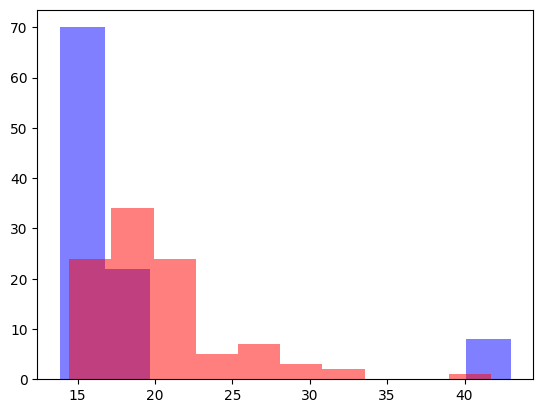

In [144]:
plt.hist(divs_exploit, color=[0, 0, 1, 0.5]);
plt.hist(divs_explore, color=[1, 0, 0, 0.5]);

In [7]:
with open('atari_games_104.txt') as f:
    env_ids = [a.strip() for a in f.readlines()]
with open('atari_games_ignore.txt') as f:
    env_ids_ignore = [a.strip() for a in f.readlines()]
env_ids = [a for a in env_ids if a not in env_ids_ignore]
for env_id in env_ids:
    print(env_id)
    env = MyEnvpool(f'{env_id}-v5', full_action_space=True, use_fire_reset=False, num_envs=8, img_height=84, img_width=84, gray_scale=True, stack_num=1, frame_skip=4, repeat_action_probability=0.0, noop_max=1)
    obs, _ = env.reset()
    for i in range(100):
        action = np.random.randint(0, 18, env.num_envs)
        action[action==1] = 0
        obs, _, _, _, _ = env.step(action)
    
    if not obs.var(axis=0).max()>0.:
        print(f'--------{env_id} NEEDS FIRE RESET -------------------')

Adventure
AirRaid
Alien
Amidar
Assault
Asterix
Asteroids
Atlantis
Atlantis2
Backgammon
BankHeist
BasicMath
BattleZone
BeamRider
Berzerk
Blackjack
Bowling
Boxing
Breakout
Carnival
Casino
Centipede
ChopperCommand
CrazyClimber
Crossbow
Darkchambers
Defender
DemonAttack
DonkeyKong
DoubleDunk
Earthworld
ElevatorAction
Enduro
Entombed
Et
FishingDerby
FlagCapture
Freeway
Frostbite
Galaxian
Gopher
Gravitar
Hangman
HauntedHouse
Hero
HumanCannonball
IceHockey
Jamesbond
JourneyEscape
Kaboom
Kangaroo
KeystoneKapers
Klax
Koolaid
Krull
KungFuMaster
LaserGates
MarioBros
MiniatureGolf
MontezumaRevenge
MrDo
MsPacman
NameThisGame
Othello
Pacman
Phoenix
Pitfall
Pitfall2
Pong
Pooyan
PrivateEye
Qbert
Riverraid
RoadRunner
Robotank
Seaquest
SirLancelot
Solaris
SpaceInvaders
SpaceWar
StarGunner
Superman
Surround
Tennis
Tetris
TicTacToe3d
TimePilot
Trondead
Turmoil
Tutankham
UpNDown
Venture
VideoCheckers
VideoChess
VideoCube
VideoPinball
WizardOfWor
WordZapper
YarsRevenge
Zaxxon


In [164]:
with open('atari_games_104.txt') as f:
    env_ids = [a.strip() for a in f.readlines()]

In [ ]:
for env_id in env_ids:
    try:
        archive = np.load(f'data/goexplore/goexplore_{env_id}_0.npy', allow_pickle=True).item()
    except:
        pass

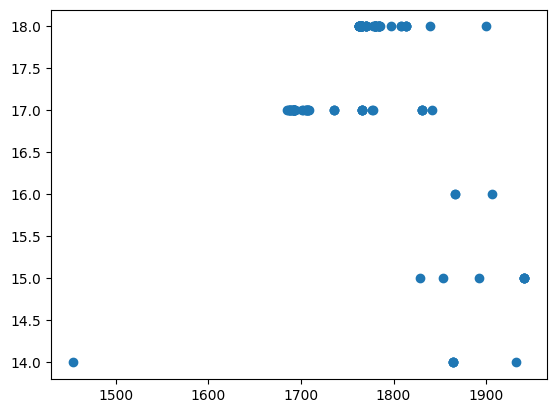

In [5]:
with open('atari_games_104.txt') as f:
    env_ids = [a.strip() for a in f.readlines()]

In [6]:
env_id2archives = defaultdict(list)

In [7]:
for env_id in tqdm(env_ids):
    for seed in range(0, 1):
        f = f'./data/goexplore/goexplore_{env_id}_{seed}.npy'
        if os.path.exists(f):
            print(f'Trying {env_id}')
            archive = np.load(f'./data/goexplore/goexplore_{env_id}_{seed}.npy', allow_pickle=True).item()
            env_id2archives[env_id].append(archive)
        
        
env_id2archives = dict(env_id2archives)

  0%|          | 0/104 [00:00<?, ?it/s]

Trying Alien
Trying Amidar
Trying Assault
Trying Asterix
Trying Asteroids
Trying Atlantis
Trying BankHeist
Trying BattleZone
Trying BeamRider
Trying Berzerk
Trying Bowling
Trying Boxing
Trying Breakout
Trying Centipede
Trying ChopperCommand
Trying CrazyClimber
Trying Defender
Trying DemonAttack
Trying DoubleDunk
Trying Enduro
Trying FishingDerby
Trying Freeway
Trying Frostbite
Trying Gopher
Trying Gravitar
Trying Hero
Trying IceHockey
Trying Jamesbond
Trying Kangaroo
Trying Krull
Trying KungFuMaster
Trying MontezumaRevenge
Trying MsPacman
Trying NameThisGame
Trying Phoenix
Trying Pitfall
Trying Pong
Trying PrivateEye
Trying Qbert
Trying Riverraid
Trying RoadRunner
Trying Robotank
Trying Seaquest
Trying Solaris
Trying SpaceInvaders
Trying StarGunner
Trying Surround
Trying Tennis
Trying TimePilot
Trying Tutankham
Trying UpNDown
Trying Venture
Trying VideoPinball
Trying WizardOfWor
Trying YarsRevenge
Trying Zaxxon


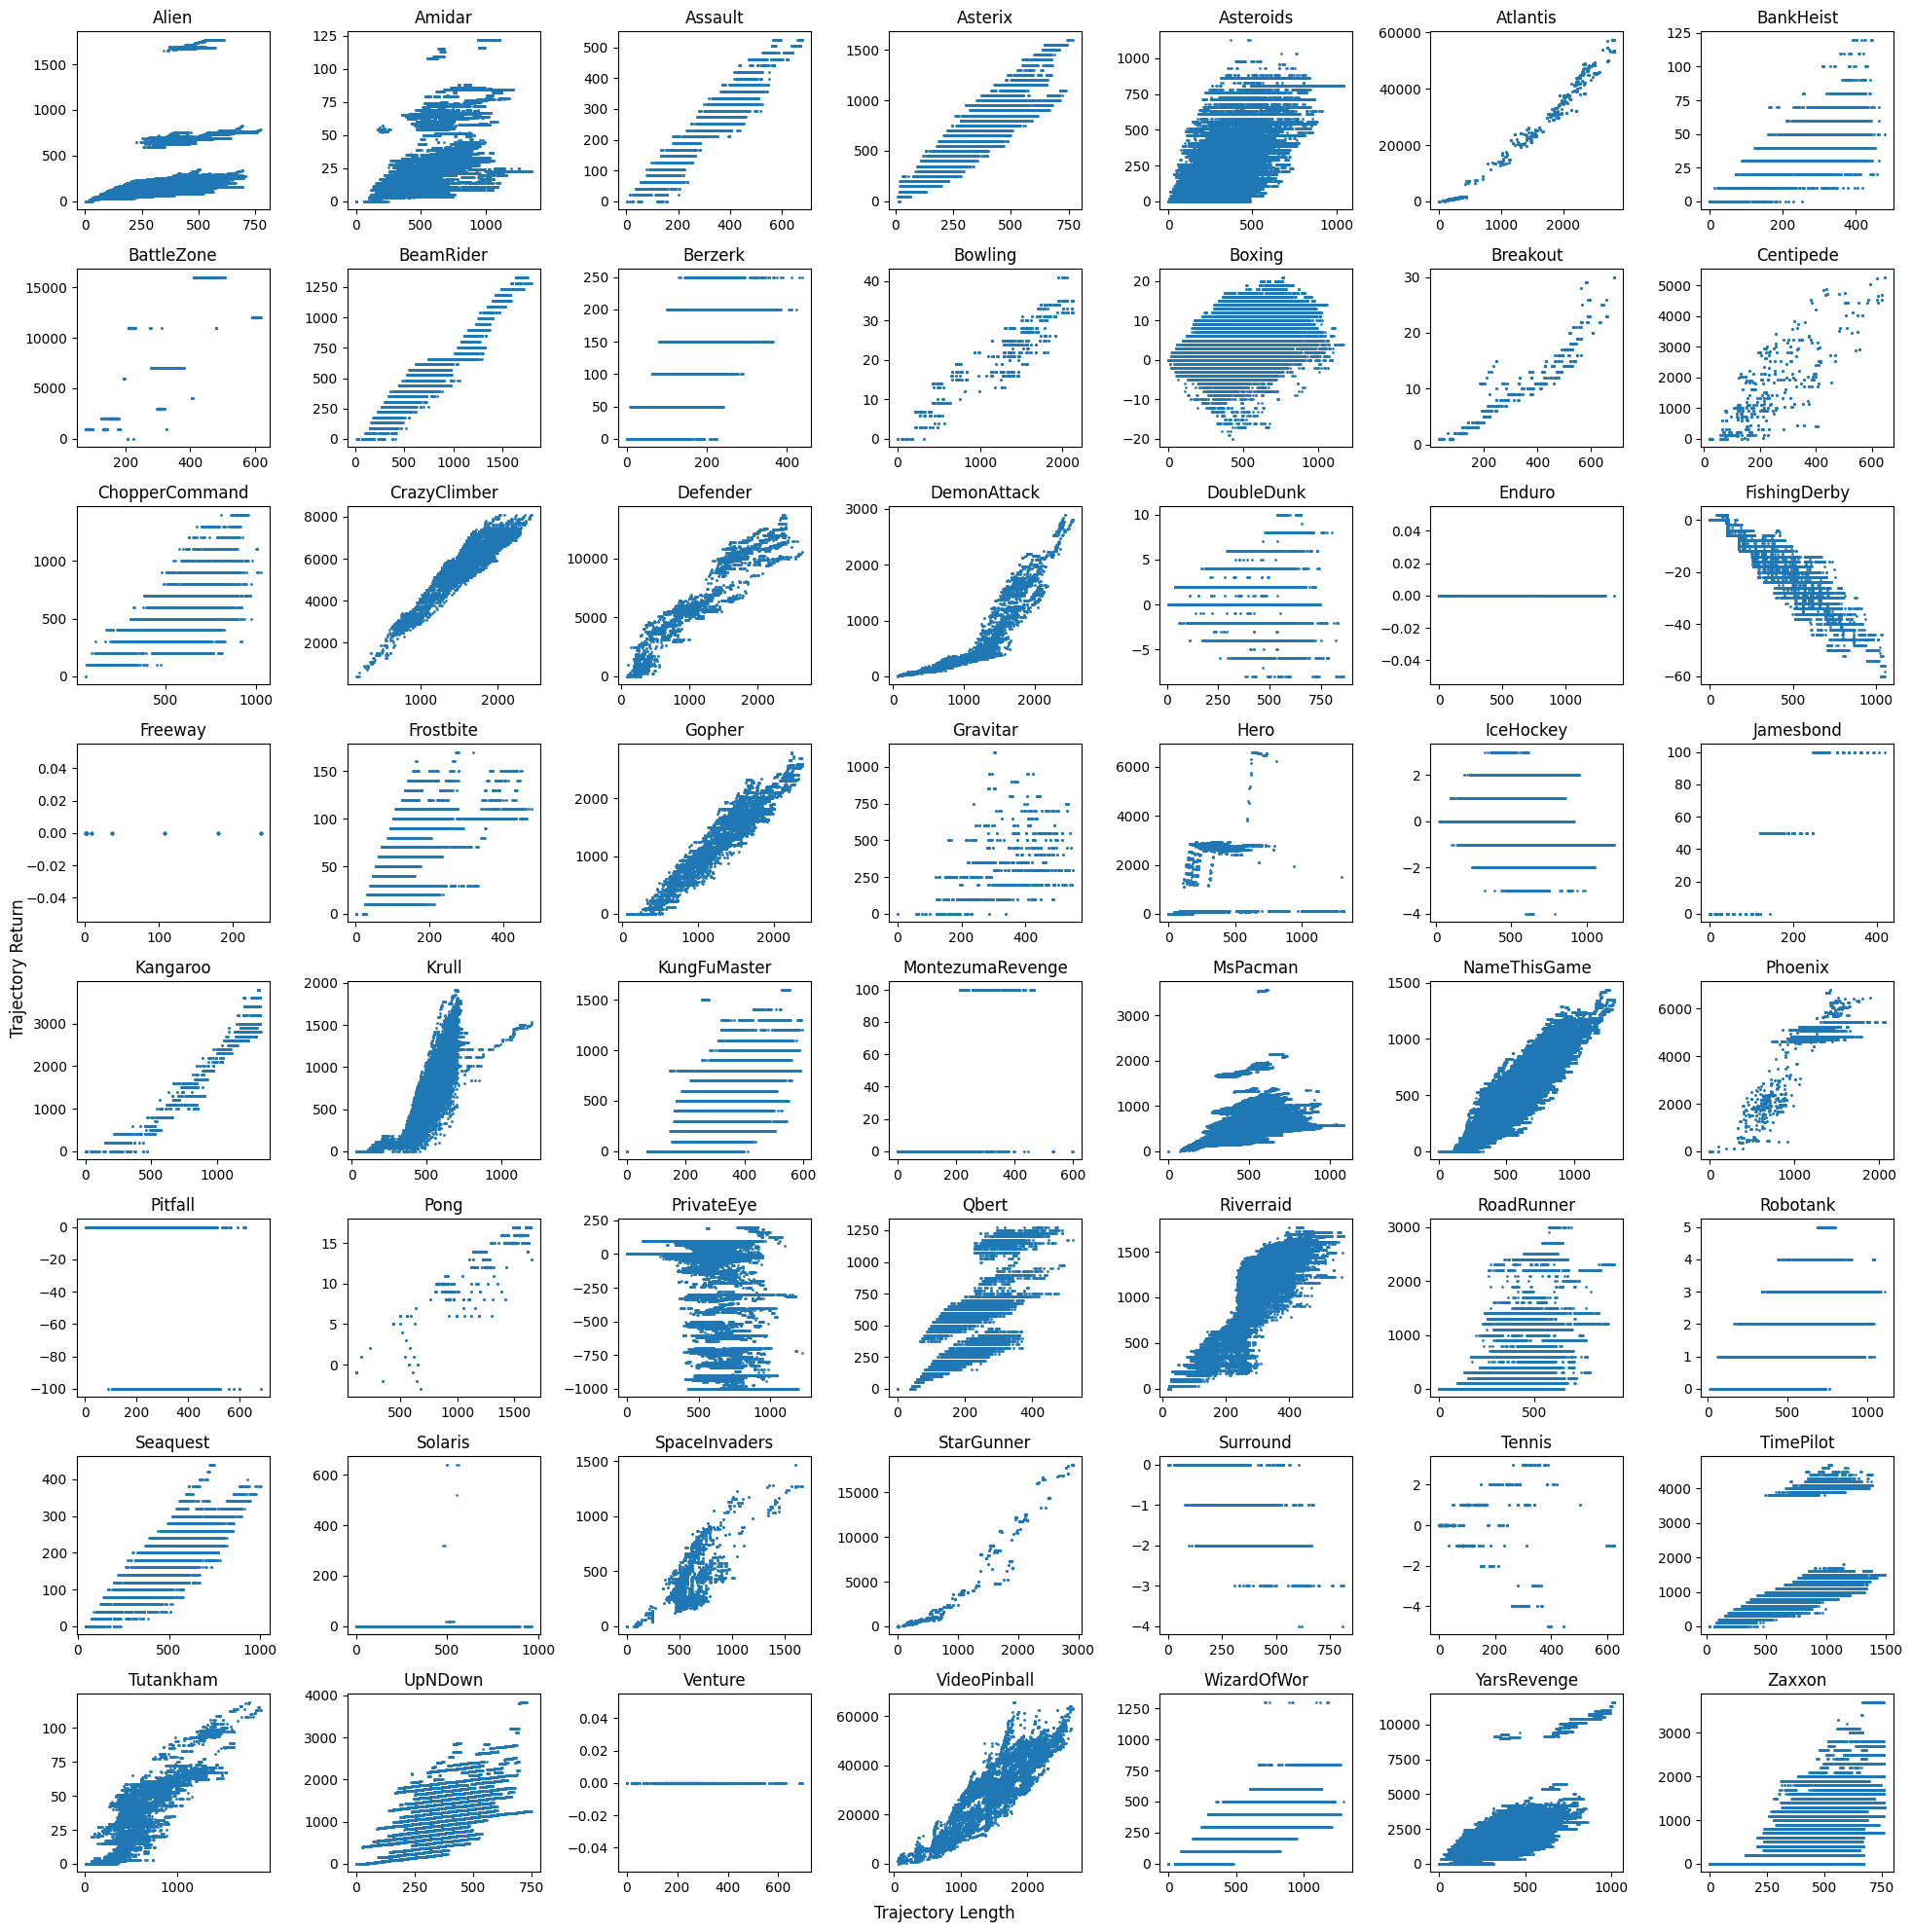

In [88]:
fig = plt.figure(figsize=(20, 20))
for i, env_id in enumerate(archives):
    plt.subplot(8, 7, i+1)
    cells = []
    for seed in archives[env_id]:
        archive = archives[env_id][seed]
        cells.extend(list(archive.values()))
    rets = [cell.running_ret for cell in cells]
    tlens = [len(cell.trajectory) for cell in cells]
    plt.scatter(tlens, rets, s=10/np.log(len(rets)))
    plt.title(env_id)
fig.supxlabel("Trajectory Length")
fig.supylabel("Trajectory Return")
# plt.suptitle("Trajectory Return vs Trajectory Length")
plt.tight_layout()
plt.show()


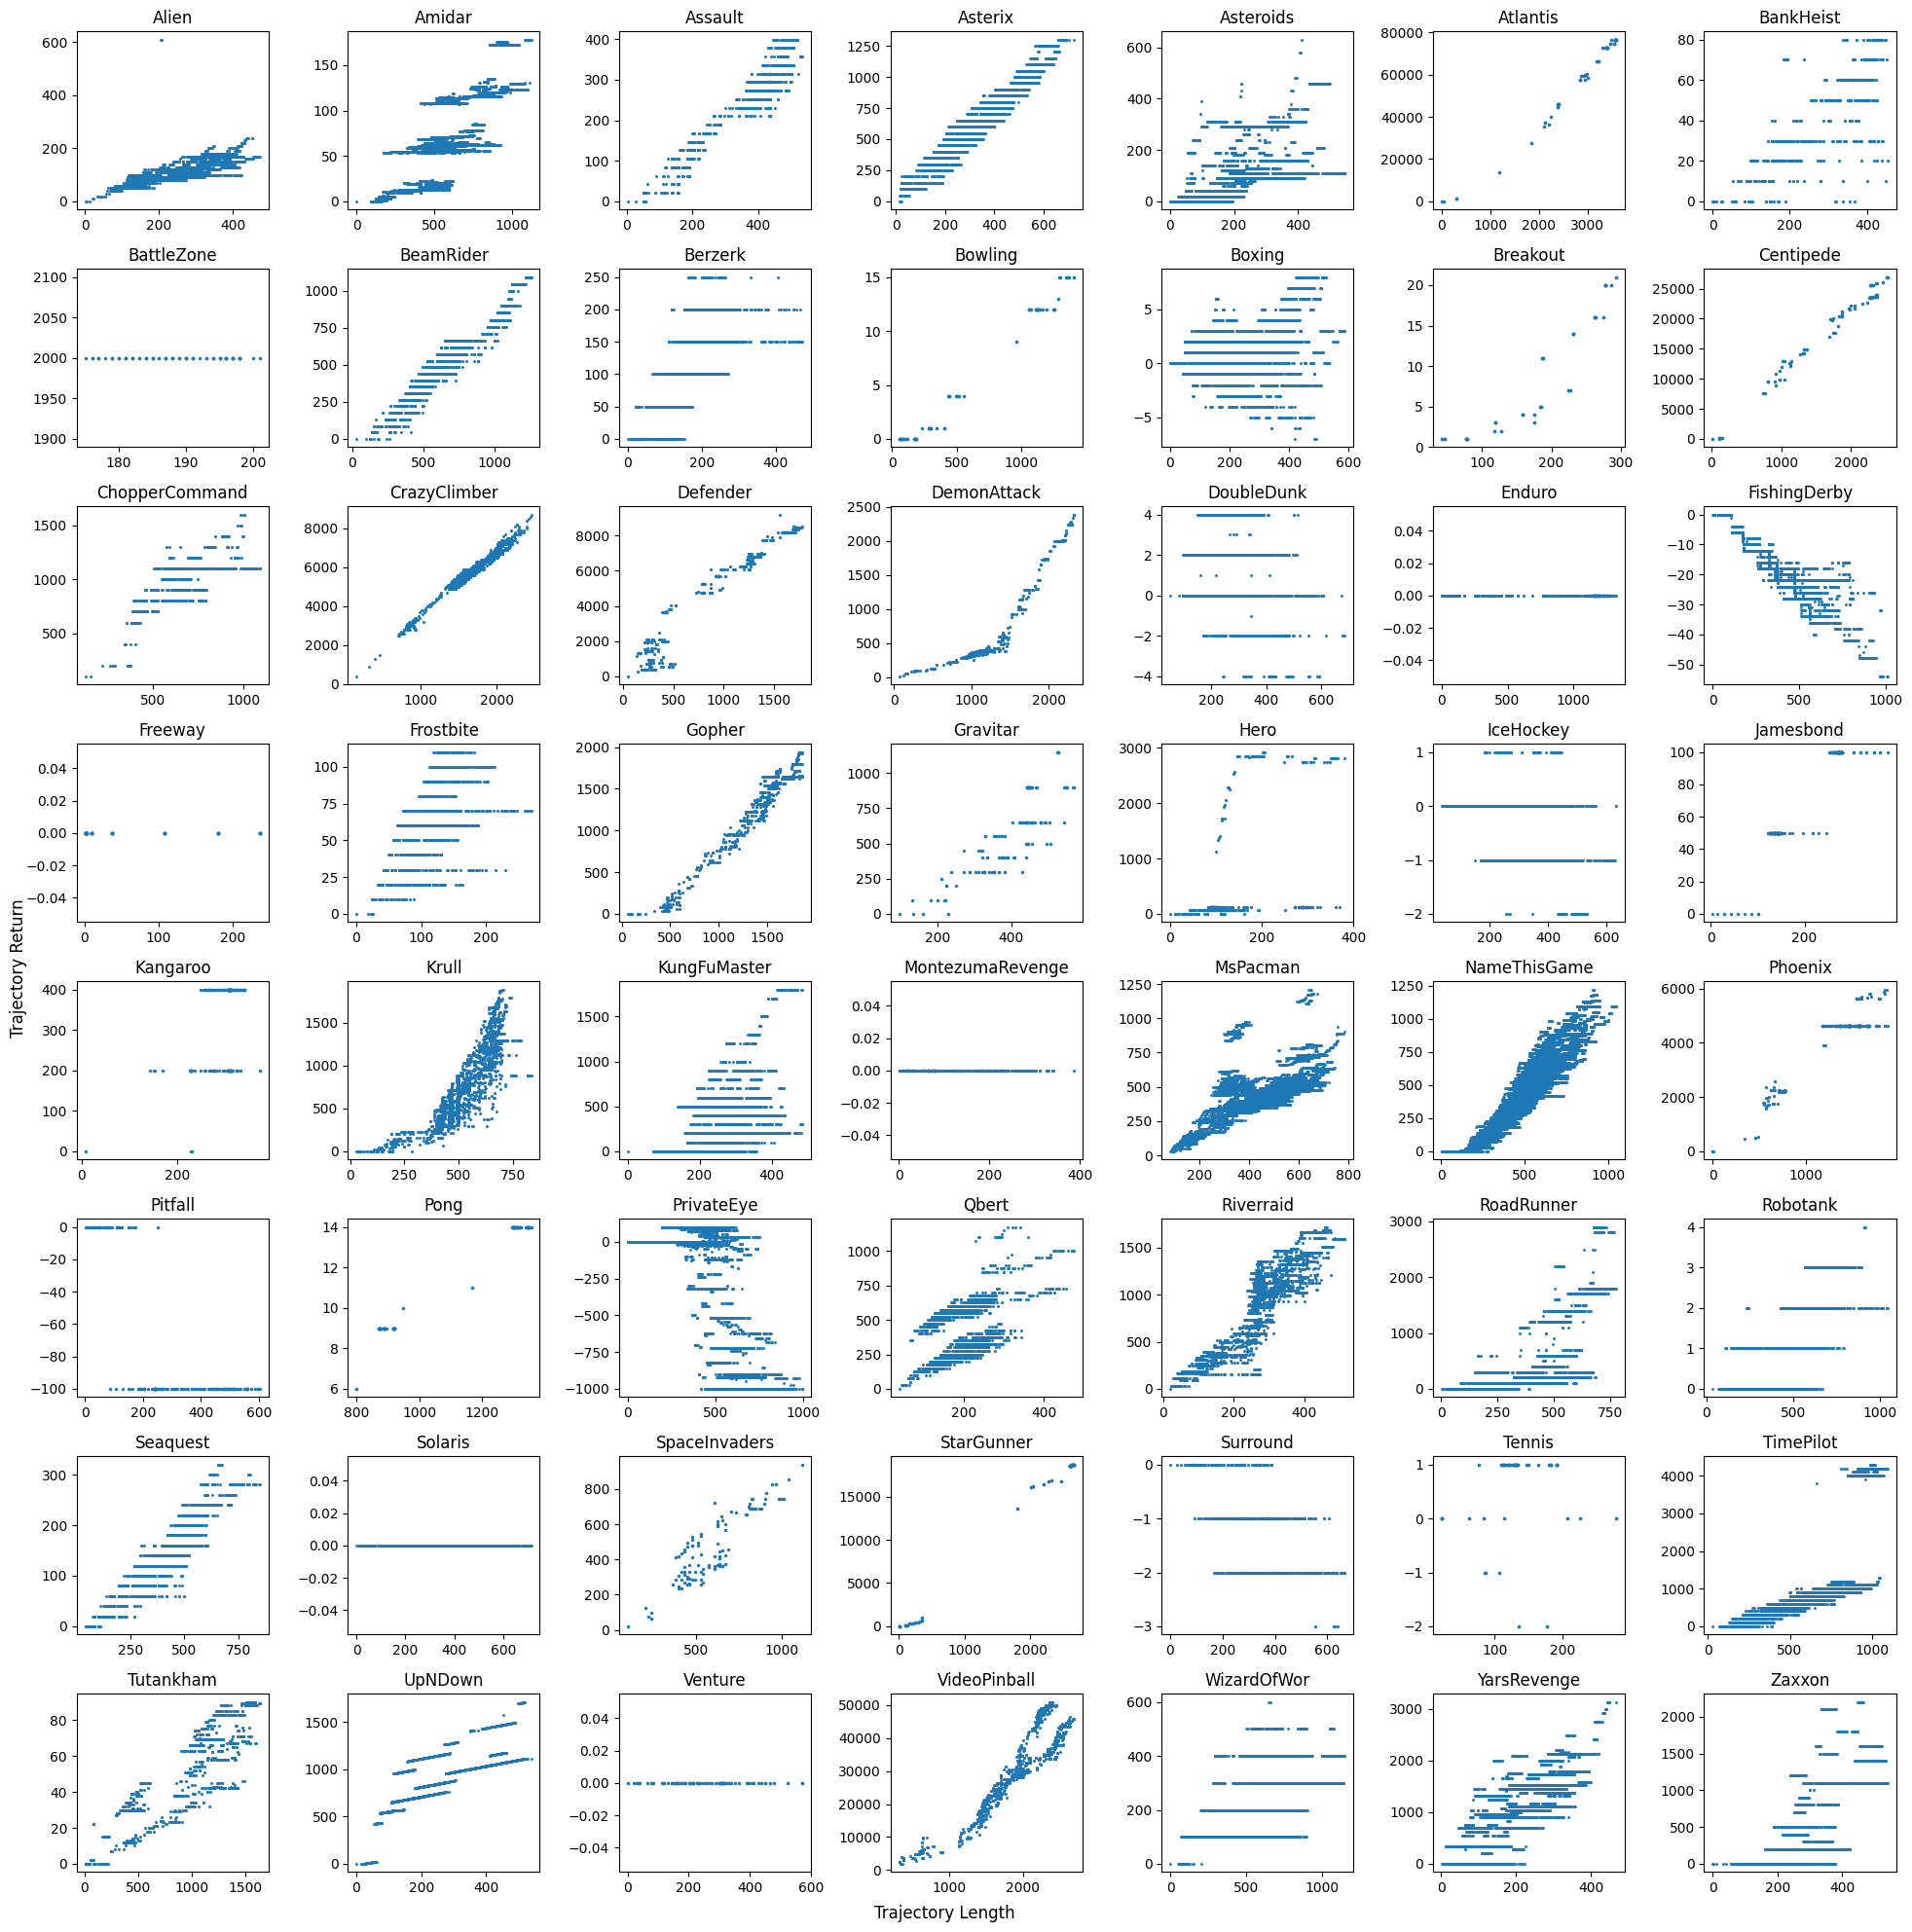

In [12]:
fig = plt.figure(figsize=(20, 20))
for i, (env_id, archives) in enumerate(env_id2archives.items()):
    plt.subplot(8, 7, i+1)
    cells = []
    for archive in archives:
        cells.extend(list(archive.values()))
    rets = [cell.running_ret for cell in cells]
    tlens = [len(cell.trajectory) for cell in cells]
    plt.scatter(tlens, rets, s=10/np.log(len(rets)))
    plt.title(env_id)
fig.supxlabel("Trajectory Length")
fig.supylabel("Trajectory Return")
# plt.suptitle("Trajectory Return vs Trajectory Length")
plt.tight_layout()
plt.show()


In [11]:
class GEBuffer(Buffer):
    def __init__(self, env, n_steps, sample_traj_fn, device=None):
        super().__init__(env, n_steps, device=device)
        self.trajs = [None for _ in range(self.env.n_envs)]
        self.traj_lens = np.zeros(self.env.n_envs, dtype=int)
        self.i_locs = np.zeros(self.env.n_envs, dtype=int)
        self.sample_traj_fn = sample_traj_fn
        
    def sample_new_traj(self, ids):
        for id in ids:
            self.trajs[id] = self.sample_traj_fn()
            self.traj_lens[id] = len(self.trajs[id])
            self.i_locs[id] = 0
        obs, _ = self.env.reset_subenvs(ids)
        self.next_obs[ids] = torch.from_numpy(obs).to(self.device)
    
    def gecollect(self, pbar=None):
        if self.first_collect:
            self.first_collect = False
            _, info = env.reset()
            self.next_obs = info['obs']
            self.sample_new_traj(np.arange(self.env.num_envs))
        for t in range(self.n_steps):
            self.obss[:, t] = self.next_obs
            action = np.array([traj[i_loc] for traj, i_loc in zip(self.trajs, self.i_locs)])
            self.i_locs += 1
            self.acts[:, t] = torch.from_numpy(action)
            _, _, _, _, info = env.step(action)
            self.next_obs = info['obs']
            self.sample_new_traj(np.where(self.i_locs>=self.traj_lens)[0])

In [14]:
np.random.seed(0)
torch.manual_seed(0)
env = MyEnvpool('MontezumaRevenge-v5', num_envs=8, img_height=84, img_width=84, gray_scale=True, stack_num=1, frame_skip=4, repeat_action_probability=0.0, noop_max=1, use_fire_reset=False)
env = ToTensor(env, device=device)
gebuff = GEBuffer(env, 1024, sample_traj_fn=lambda : best_cell.trajectory, device=device)
# gebuff = GEBuffer(env, 1024, sample_traj_fn=lambda : np.random.choice(cells).trajectory, device=device)


gebuff.gecollect()

NameError: name 'device' is not defined

In [ ]:
len(best_cell.trajectory)

In [174]:
gebuff.obss.shape

torch.Size([8, 1024, 1, 84, 84])

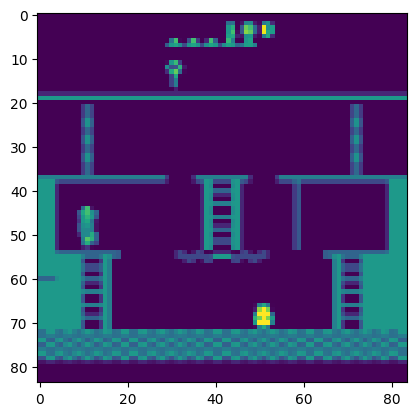

In [179]:
plt.imshow(gebuff.obss[0, 302, 0].detach().cpu().numpy())

In [43]:
def sample_traj(archives, sampling='uniform'):
    archive = np.random.choice(archives)
    cells = list(archive.values())
    rets = [cell.running_ret for cell in cells]
    # tlens = [len(cell.trajectory) for cell in cells]
    ret_best = np.max(rets)
    cells_best = [cell for cell in cells if cell.running_ret==ret_best]
    if sampling=='uniform':
        return np.random.choice(cells).trajectory
    elif sampling=='best_n':
        return np.random.choice(cells_best).trajectory
    elif sampling=='best_1':
        return cells_best[-1].trajectory

In [44]:
device=None

In [45]:
mbuffer = MultiBuffer()
for env_id in tqdm(env_id2archives):
    env = MyEnvpool(f'{env_id}-v5', num_envs=8, img_height=84, img_width=84, gray_scale=True, stack_num=1, frame_skip=4, repeat_action_probability=0.0, noop_max=1, use_fire_reset=False, full_action_space=True)
    env = ToTensor(env, device=device)
    gebuff = GEBuffer(env, 128, sample_traj_fn=partial(sample_traj, archives=env_id2archives[env_id], sampling='best_1'), device=device)
    mbuffer.buffers.append(gebuff)


  0%|          | 0/56 [00:00<?, ?it/s]

In [46]:
for buf in tqdm(mbuffer.buffers):
    buf.gecollect()

  0%|          | 0/56 [00:00<?, ?it/s]

In [47]:
batch = mbuffer.generate_batch(56*8, 4)

In [48]:
batch['obs'].shape, batch['act'].shape

(torch.Size([448, 4, 1, 84, 84]), torch.Size([448, 4]))

In [49]:
agent = DecisionTransformer(18, 4)
opt = agent.create_optimizer(1e-4)

num decayed parameter tensors: 24, with 4,026,368 parameters
num non-decayed parameter tensors: 41, with 14,515 parameters
using fused AdamW: False


In [50]:
logits, values = agent(None, batch['obs'], batch['act'], None)

In [51]:
logits.shape

torch.Size([448, 4, 18])

In [ ]:
bs = 56*8
for _ in tqdm(range(64)):
    batch = mbuffer.generate_batch(bs, 4)

    logits, values = agent(None, batch['obs'], batch['act'], None)
    
    loss_ce = torch.nn.functional.cross_entropy(rearrange(logits, 'b t d -> (b t) d'), rearrange(batch['act'], 'b t -> (b t)'), reduction='none')
    loss_ce = rearrange(loss_ce, '(b t) -> b t', b=bs)
    loss = loss_ce.mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(np.e**loss.item())
    

  0%|          | 0/64 [00:00<?, ?it/s]

In [25]:
env_id = 'MontezumaRevenge'
for archive in env_id2archives[env_id]:
    print(env_id)
    print(f'n_cells: {len(archive)}')
    cells = list(archive.values())
    rets = [cell.running_ret for cell in cells]
    tlens = [len(cell.trajectory) for cell in cells]
    print(f'longest traj: {max(tlens)}')
    print(f'best traj: {max(rets)}')

    print()

MontezumaRevenge
n_cells: 678
longest traj: 386
best traj: 0.0



In [15]:
a = {env_id: len(archives[0]) for env_id, archives in env_id2archives.items()}

In [17]:
a = {k: v for k, v in sorted(a.items(), key=lambda item: item[1])}


In [18]:
a

{'Freeway': 8,
 'Breakout': 31,
 'StarGunner': 43,
 'Tennis': 49,
 'Atlantis': 61,
 'Bowling': 66,
 'Pong': 73,
 'Centipede': 74,
 'Venture': 79,
 'BattleZone': 84,
 'SpaceInvaders': 109,
 'Gravitar': 115,
 'Kangaroo': 146,
 'Pitfall': 201,
 'Phoenix': 368,
 'Jamesbond': 413,
 'BankHeist': 425,
 'Defender': 479,
 'DemonAttack': 491,
 'Hero': 549,
 'Surround': 592,
 'MontezumaRevenge': 678,
 'Enduro': 845,
 'Gopher': 970,
 'Assault': 1076,
 'Tutankham': 1252,
 'VideoPinball': 1469,
 'Frostbite': 1474,
 'ChopperCommand': 1491,
 'Krull': 2027,
 'BeamRider': 2081,
 'CrazyClimber': 2090,
 'Qbert': 2565,
 'Asteroids': 2766,
 'Berzerk': 2968,
 'Riverraid': 3204,
 'Alien': 3464,
 'DoubleDunk': 3750,
 'IceHockey': 3825,
 'Seaquest': 3873,
 'YarsRevenge': 4056,
 'Zaxxon': 4210,
 'Boxing': 4868,
 'KungFuMaster': 5022,
 'UpNDown': 5599,
 'Amidar': 6122,
 'RoadRunner': 6258,
 'Asterix': 6925,
 'TimePilot': 7055,
 'FishingDerby': 7372,
 'PrivateEye': 9704,
 'WizardOfWor': 10222,
 'Robotank': 10264,


In [33]:
a = np.load('./data/test/original.npy', allow_pickle=True).item()

In [34]:
a = list(a.values())

In [35]:
a = [np.array(cell.trajectory, dtype=np.uint8) for cell in a]

In [39]:
a = np.array(a, dtype=object)

In [40]:
np.save('./data/test/new.npy', a)

In [92]:
archive = np.load('./data/goexplore/goexplore_BeamRider_0.npy', allow_pickle=True).item()

In [93]:
trajs, rets, scores = archive['trajs'], archive['rets'], archive['scores']

In [94]:
best_traj = trajs[rets==np.max(rets)][-1]

In [113]:
len(best_traj)

1500

In [137]:
env = gym.make(f"ALE/BeamRider-v5", frameskip=1, repeat_action_probability=0.0, full_action_space=True)
env = gym.wrappers.AtariPreprocessing(env, noop_max=1, frame_skip=4, screen_size=210, grayscale_obs=False)

obs, info = env.reset()
o = []
for i, action in enumerate(best_traj):
    o.append(obs)
    o.append(env.unwrapped.ale.getRAM())
    o.append(action)
    obs, rew, term, trunc, info = env.step(action)
    assert not term and not trunc
obs, info = env.reset()
o1 = []
for i, action in enumerate(best_traj):
    o1.append(obs)
    o1.append(env.unwrapped.ale.getRAM())
    o1.append(action)
    obs, rew, term, trunc, info = env.step(action)
    assert not term and not trunc

AssertionError: 

In [138]:
for i in range(3):
    print(i)
    print(np.allclose(o[i*3], o1[i*3]))
    print(np.allclose(o[i*3+1], o1[i*3+1]))
    print(np.allclose(o[i*3+2], o1[i*3+2]))
    
    print()

0
True
False
True

1
True
False
True

2
False
False
True



In [174]:
for env_id in env_ids:
    try:
        env = gym.make(f"ALE/{env_id}-v5", frameskip=1, repeat_action_probability=0.0, full_action_space=True)
    except:
        continue
    env = gym.wrappers.AtariPreprocessing(env, noop_max=1, frame_skip=4, screen_size=210, grayscale_obs=False)
    env.reset()
    env.step(0)
    ram = env.unwrapped.ale.getRAM()
    env.reset()
    env.step(0)
    ram1 = env.unwrapped.ale.getRAM()
    if not np.allclose(ram, ram1):
        print(env_id)

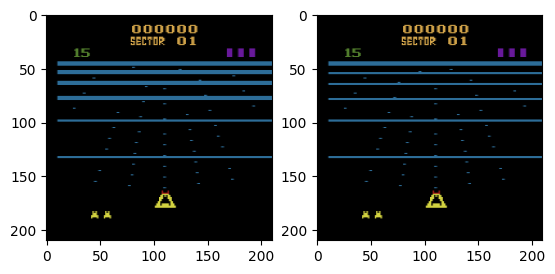

In [116]:
plt.subplot(121)
plt.imshow(o[2])
plt.subplot(122)
plt.imshow(o1[2])

In [89]:
term, trunc

(False, False)

In [67]:
env = MyEnvpool(
    f"{'Amidar'}-v5", num_envs=1, img_height=84, img_width=84, gray_scale=True, stack_num=1, frame_skip=4, repeat_action_probability=0.0, noop_max=1, use_fire_reset=False, full_action_space=True
)
env.reset()
for i, action in enumerate(best_traj):
    obs, rew, term, trunc, info = env.step(np.array(action)[None])
    assert not term and not trunc

In [29]:
print(i)

1079


In [30]:
term, trunc

(False, False)

In [51]:
env1 = gym.make(f"ALE/Amidar-v5", frameskip=1, repeat_action_probability=0.0, full_action_space=True)
env1 = gym.wrappers.AtariPreprocessing(env1, noop_max=1, frame_skip=4, screen_size=210, grayscale_obs=False)

env2 = MyEnvpool(
    f"{'Amidar'}-v5", num_envs=1, img_height=84, img_width=84, gray_scale=True, stack_num=1, frame_skip=4, repeat_action_probability=0.0, noop_max=1, use_fire_reset=False, full_action_space=True
)

In [52]:
obs1, _ = env1.reset()
obs2, _ = env2.reset()

for i in range(1000):
    a = np.random.randint(0, 18, size=(1, ))
    obs1, rew1, term1, trunc1, info1 = env1.step(a.item())
    obs2, rew2, term2, trunc2, info2 = env2.step(a)

IndexError: list index out of range

In [54]:
a.item()

15

In [184]:
import glob
with open('atari_games_104.txt') as f:
    env_ids = [a.strip() for a in f.readlines()]

env_id2archives = defaultdict(list)
for env_id in tqdm(env_ids):
    for f in glob.glob(f'./data/goexplore/*{env_id}*'):
        archive = np.load(f, allow_pickle=True).item()
        env_id2archives[env_id].append(archive)
env_id2archives = dict(env_id2archives)

  0%|          | 0/104 [00:00<?, ?it/s]

In [209]:
for env_id, archives in tqdm(env_id2archives.items()):
    env = gym.make(f"ALE/{env_id}-v5", frameskip=1, repeat_action_probability=0.0, full_action_space=True)
    env = gym.wrappers.AtariPreprocessing(env, noop_max=1, frame_skip=4, screen_size=210, grayscale_obs=False)
    archive = archives[0]
    trajs, rets, scores = archive['trajs'], archive['rets'], archive['scores']
    traj = trajs[rets==np.max(rets)][-1]
    env = gym.make(f"ALE/{env_id}-v5", frameskip=1, repeat_action_probability=0.0, full_action_space=True)
    env = gym.wrappers.AtariPreprocessing(env, noop_max=1, frame_skip=4, screen_size=210, grayscale_obs=False)
    
    rams = []
    for i in tqdm(range(10)):
        rams.append([])
        env.reset()
        for j, action in enumerate(traj):
            rams[-1].append(env.unwrapped.ale.getRAM())
            env.step(action)
    rams = np.array(rams)
    if rams.var(axis=0).any():
        print(env_id)

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Assault


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

BeamRider


  0%|          | 0/10 [00:00<?, ?it/s]

Berzerk


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

ChopperCommand


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

DemonAttack


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

FishingDerby


  0%|          | 0/10 [00:00<?, ?it/s]

Freeway


  0%|          | 0/10 [00:00<?, ?it/s]

Frostbite


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Hero


  0%|          | 0/10 [00:00<?, ?it/s]

IceHockey


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Krull


  0%|          | 0/10 [00:00<?, ?it/s]

KungFuMaster


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

PrivateEye


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Seaquest


  0%|          | 0/10 [00:00<?, ?it/s]

Solaris


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Surround


  0%|          | 0/10 [00:00<?, ?it/s]

Tennis


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

YarsRevenge


  0%|          | 0/10 [00:00<?, ?it/s]

In [259]:
for env_id in ['ChopperCommand']:
    archives = env_id2archives[env_id]
    archive = archives[0]
    trajs, rets, scores = archive['trajs'], archive['rets'], archive['scores']
    traj = trajs[rets==np.max(rets)][-1]
    
    env = gym.make(f"ALE/{env_id}-v5", frameskip=1, repeat_action_probability=0.0, full_action_space=True)
    env = gym.wrappers.AtariPreprocessing(env, noop_max=1, frame_skip=4, screen_size=210, grayscale_obs=False)
    
    rams = []
    for i in tqdm(range(10)):
        rams.append([])
        env = gym.make(f"ALE/{env_id}-v5", frameskip=1, repeat_action_probability=0.0, full_action_space=True)
        env = gym.wrappers.AtariPreprocessing(env, noop_max=1, frame_skip=4, screen_size=210, grayscale_obs=False)
        env.reset()
        for j, action in enumerate(traj):
            rams[-1].append(env.unwrapped.ale.getRAM())
            env.step(action)
    rams = np.array(rams)
    if rams.var(axis=0).any():
        print(env_id)

  0%|          | 0/10 [00:00<?, ?it/s]

In [260]:
rams.var(axis=0).any(axis=-1).any()

False

In [251]:
for i in range(10):
    print((rams[i, 0]-ram0).any())

False
False
False
False
True
False
False
False
False
False


In [246]:
rams[:, 0, 0]

array([72, 72, 72, 72, 73, 72, 72, 72, 72, 72], dtype=uint8)

In [248]:
rams[4, 0]-ram0

array([  1,   0,   0,   0,   0, 130, 130, 252, 254,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0, 220, 112, 180,   9,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1, 234,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  53, 227,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=uint8)

In [223]:
rams.shape

(10, 1008, 128)

In [224]:
env = gym.make(f"ALE/{env_id}-v5", frameskip=1, repeat_action_probability=0.0, full_action_space=True)
env = gym.wrappers.AtariPreprocessing(env, noop_max=1, frame_skip=4, screen_size=210, grayscale_obs=False)
env.reset()
ram0 = env.unwrapped.ale.getRAM()
env.reset()
ram1 = env.unwrapped.ale.getRAM()

In [225]:
ram0

array([ 72,   0, 240, 255, 255, 251, 121, 125, 127, 249, 121, 189, 223,
         0,   0,   0,   0, 240,   0,   0,   0,   2,  40,  66,  91,   0,
       184,   0,   0,  80,  96,  96,  96,   4,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   7,   0,
         0, 255, 254,   0, 240, 240,   0, 255, 224,   0,   1,   0,   0,
        64,   1,   0,  80,  80,   0, 133,  56, 182, 254,  64, 254,   0,
        21,   1,   0, 186,   3,   3,   0,  48,  48, 192,  12,   3, 192,
       192,  12,   3, 240, 240,   0,  88,  12,  12,   3,   4,  71, 233,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  52, 226, 255,
         0,  44, 210,  16, 136,  48,  16,  85, 242,  66, 253], dtype=uint8)

In [234]:
for _ in range(10):
    env = gym.make(f"ALE/{'DemonAttack'}-v5", frameskip=1, repeat_action_probability=0.0, full_action_space=True)
    env = gym.wrappers.AtariPreprocessing(env, noop_max=1, frame_skip=4, screen_size=210, grayscale_obs=False)
    rams = []
    for i in range(20):
        o, _ = env.reset()
        rams.append(env.unwrapped.ale.getRAM())
    rams = np.array(rams)
    print(rams[:, 47])

[0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0]


In [56]:
np.where(rams.var(axis=0))

(array([47, 49, 50, 59, 61, 68, 71, 75, 85, 89, 91]),)

In [59]:
rams.shape

(10, 128)

In [220]:
archive = np.load('./data/goexplore/goexplore_Alien_0.npy', allow_pickle=True).item()

In [222]:
trajs = archive['trajs']

In [226]:
len(trajs), sum([len(i) for i in trajs])

(25723, 9024829)

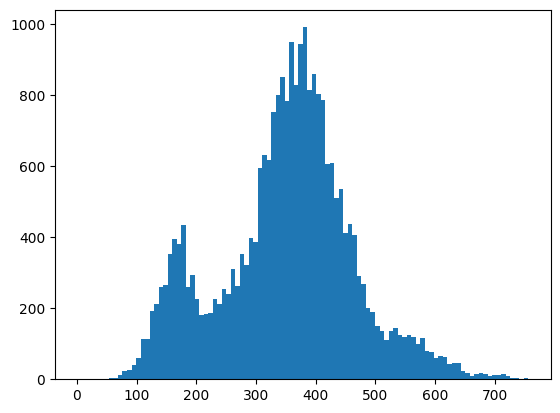

In [228]:
plt.hist([len(i) for i in trajs], bins=100);

In [245]:
o = []
for seed in range(5):
    env = gym.make(f"ALE/Alien-v5", frameskip=1, repeat_action_probability=0.0)
    obs, _ = env.reset(seed=seed)
    o.append(obs)

In [246]:
o = np.stack(o)

In [247]:
o.shape

(5, 210, 160, 3)

In [248]:
o.var(axis=0).max()

0.0

In [ ]:
env = gym.make(f"ALE/MontezumaRevenge-v5", frameskip=1, repeat_action_probability=0.0)
env = gym.wrappers.AtariPreprocessing(env, noop_max=1, frame_skip=4, screen_size=210, grayscale_obs=False)
env.reset()

env.restore_state(cell.ram)
obs1, _, _, _, _ = env.step(0)
ram1 = env.ale.getRAM()

env.reset()
for a in cell.trajectory[:]:
    env.step(a)
obs2, _, _, _, _ = env.step(0)
ram2 = env.ale.getRAM()

# assert np.allclose(ram1, ram2)
# assert np.allclose(obs1, obs2)

env = envpool.make_gymnasium('MontezumaRevenge-v5', img_height=210, img_width=210, gray_scale=False, stack_num=1, frame_skip=4, repeat_action_probability=0.0, noop_max=1, use_fire_reset=False)
env.reset()
for a in cell.trajectory[:]:
    env.step(np.array([a]))
obs3, _, _, _, _ = env.step(np.array([0]))
obs3 = rearrange(obs3, '1 c h w -> h w c')

plt.figure(figsize=(15, 5))
plt.subplot(131);plt.imshow(obs1)
plt.subplot(132);plt.imshow(obs2)
plt.subplot(133);plt.imshow(obs3)

In [254]:
'wtf'.format(a=3, b=4)

'wtf'

dict_keys(['trajs', 'rets', 'scores'])


In [306]:
import time

In [323]:
a = copy.deepcopy(env.unwrapped._np_random)

In [326]:
env = gym.make(f"ALE/ChopperCommand-v5", frameskip=1, repeat_action_probability=0.0)
rams = []
ts = [time.time()]
for i in tqdm(range(100)):
    env.reset(seed=0)
    rams.append(env.ale.getRAM().copy())
    ts.append(time.time())
rams = np.stack(rams)
rams.var(axis=0)

  0%|          | 0/100 [00:00<?, ?it/s]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [320]:
import copy

array([9.00000e-02, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       1.42884e+03, 3.60000e-01, 3.60000e-01, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 9.00000e-02, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.000

In [446]:
class GEBuffer(Buffer):
    def __init__(self, env, n_steps, sample_traj_fn, device=None):
        super().__init__(env, n_steps, device=device)
        self.trajs = [None for _ in range(self.env.num_envs)]
        self.traj_lens = np.zeros(self.env.num_envs, dtype=int)
        self.i_locs = np.zeros(self.env.num_envs, dtype=int)
        self.sample_traj_fn = sample_traj_fn

        self.buf_obs = np.zeros((env.num_envs, n_steps, 84, 84), dtype=np.uint8)
        self.buf_act = np.zeros((env.num_envs, n_steps), dtype=np.uint8)
        self.next_obs = np.zeros_like(env.observation_space.sample())
        env.envs[0].reset(seed=0)
        self.ram_start = env.envs[0].ale.getRAM().copy()

    def traj_over_subenv(self, id):
        self.trajs[id] = self.sample_traj_fn()
        self.traj_lens[id] = len(self.trajs[id])
        self.i_locs[id] = 0
        obs, _ = self.env.envs[id].reset(seed=0)
        assert np.array_equal(self.env.envs[id].ale.getRAM(), self.ram_start), "env reset to seed=0"
        return obs

    def gecollect(self, pbar=None):
        if self.first_collect:
            self.first_collect = False
            # obs, info = self.env.reset()
            # self.next_obs = info["obs"]
            # self.sample_new_traj(np.arange(self.env.num_envs))
            for id in range(env.num_envs):
                self.next_obs[id] = self.traj_over_subenv(id)
        
        for t in tqdm(range(self.n_steps)):
            self.buf_obs[:, t] = self.next_obs
            action = np.array([traj[i_loc] for traj, i_loc in zip(self.trajs, self.i_locs)])
            self.i_locs += 1
            self.buf_act[:, t] = action
            self.next_obs, _, term, trunc, _ = self.env.step(action)
            assert not any(term) and not any(trunc), "found a done in the ge buffer"
            # self.dones[:, t] = info["done"]
            # self.next_obs = info["obs"]
            for id in np.where(self.i_locs >= self.traj_lens)[0]:
                self.next_obs[id] = self.traj_over_subenv(id)
            
def make_ge_env_single(env_id):
    env = gym.make(f"ALE/{env_id}-v5", frameskip=1, repeat_action_probability=0.0, full_action_space=True)
    env = gym.wrappers.AtariPreprocessing(env, noop_max=1, frame_skip=4, screen_size=84, grayscale_obs=True)
    return env
def make_ge_env(env_id, n_envs):
    make_fn = partial(make_ge_env_single, env_id=env_id)
    return gym.vector.SyncVectorEnv([make_fn for _ in range(n_envs)])

env = make_ge_env(env_id, 8)
buf = GEBuffer(env, 512, sample_traj_fn=lambda : np.random.choice(trajs))
buf.gecollect()

  0%|          | 0/512 [00:00<?, ?it/s]

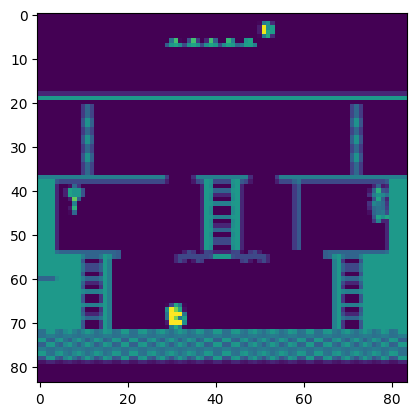

511


In [447]:
for t in range(512):
    clear_output(wait=True)
    
    plt.imshow(buf.buf_obs[0, t])
    plt.show()
    print(t)

In [431]:
env_id = 'MontezumaRevenge'

In [432]:
archive = np.load(f'/app/atari/data/goexplore/goexplore_{env_id}_0.npy', allow_pickle=True).item()
print(archive.keys())
trajs, rets, scores = archive.values()
traj_best, ret_best = trajs[np.argmax(rets)], np.max(rets)
len(traj_best), ret_best

dict_keys(['trajs', 'rets', 'scores'])


(293, 100.0)

array([ 0, 16,  5,  7, 13, 16,  1,  6, 13,  0,  0, 15, 12,  9,  3,  1, 11,
       15,  7, 12, 14,  7, 11, 12, 11, 14,  1, 16, 16, 17,  0, 15,  8,  2,
       10,  3,  7, 16,  4,  5,  6, 11,  7,  9, 16, 15, 10,  7,  3,  2,  4,
       17,  5, 14,  8,  2, 17, 16, 12,  0, 11,  0, 13,  7, 14,  5,  9,  5,
       14,  0,  9, 16], dtype=uint8)

In [369]:
env = gym.make(f"ALE/{env_id}-v5", frameskip=1, repeat_action_probability=0.0, full_action_space=True)
env = gym.wrappers.AtariPreprocessing(env, noop_max=1, frame_skip=4, screen_size=210, grayscale_obs=False)

for i in tqdm(range(10)):
    env.reset(seed=0)
    ret = 0
    for a in traj_best:
        _, rew, term, trunc, info = env.step(a)
        ret+=rew
        assert not term and not trunc
    print(ret)

  0%|          | 0/10 [00:00<?, ?it/s]

1600.0
1600.0
1600.0
1600.0
1600.0
1600.0
1600.0
1600.0
1600.0
1600.0


In [455]:
for f in os.listdir('./data/goexplore/'):
    archive = np.load(f'./data/goexplore/{f}', allow_pickle=True).item()
    print(f)
    print(len(archive['trajs']))
    print()

goexplore_Alien_0.npy
25723

goexplore_Amidar_0.npy
3905

goexplore_Assault_0.npy
833

goexplore_Asterix_0.npy
5512

goexplore_Asteroids_0.npy
11950

goexplore_Atlantis_0.npy
65

goexplore_BankHeist_0.npy
459

goexplore_BattleZone_0.npy
84

goexplore_BeamRider_0.npy
2501

goexplore_Berzerk_0.npy
3166

goexplore_Bowling_0.npy
99

goexplore_Boxing_0.npy
21512

goexplore_Breakout_0.npy
68

goexplore_Centipede_0.npy
78

goexplore_ChopperCommand_0.npy
1564

goexplore_CrazyClimber_0.npy
2175

goexplore_Defender_0.npy
564

goexplore_DemonAttack_0.npy
560

goexplore_DoubleDunk_0.npy
4038

goexplore_Enduro_0.npy
1604

goexplore_FishingDerby_0.npy
7905

goexplore_Freeway_0.npy
8

goexplore_Frostbite_0.npy
1600

goexplore_Gopher_0.npy
1085

goexplore_Gravitar_0.npy
118

goexplore_Hero_0.npy
557

goexplore_IceHockey_0.npy
15468

goexplore_Jamesbond_0.npy
432

goexplore_Kangaroo_0.npy
148

goexplore_Krull_0.npy
2102

goexplore_KungFuMaster_0.npy
5623

goexplore_MontezumaRevenge_0.npy
703

goexplore